### Deskripsi Singkat Dataset:

tulis deskripsi singkat dataset yang Anda gunakan

---

### Dataset yang diambil dari repositori:

COVID Face Mask Detection Dataset – sumber : https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

### Hasil kerja

In [185]:
import cv2
import math, time, random, datetime
import os
import numpy as np
from matplotlib import pyplot as plt
# import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import warnings
warnings.filterwarnings('ignore')

Path untuk folder data

In [111]:
TRAIN_PATH  = './kaggle/Train' #Mengandung 90% dari dataset
TEST_PATH  = './kaggle/Test' # Mengandung 10% dari dataset

IMG_SIZE = 224

### PREPROCESSING

Memberi Label pada gambar serta membagi dataset menjadi training dan validation.
PREPROCESSING: 
1. LABELLING DATA
2. MEMISAHKAN DATA (berdasarkan random seed: 123)
3. RESIZE IMAGE (menggunakan billinear interpolation)
4. COLOR MODE : GRAYSCALE

In [112]:
print("TRAINING + VALIDATION")

seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)
print("TESTING")
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)

TRAINING + VALIDATION
Found 906 files belonging to 2 classes.
Using 725 files for training.
Found 906 files belonging to 2 classes.
Using 181 files for validation.
TESTING
Found 100 files belonging to 2 classes.


Menyetelkan buffered prefetching untuk mengurangi pengambilan gambar dari disk.

Menunjukkan 9 data pertama dari dataset Training.

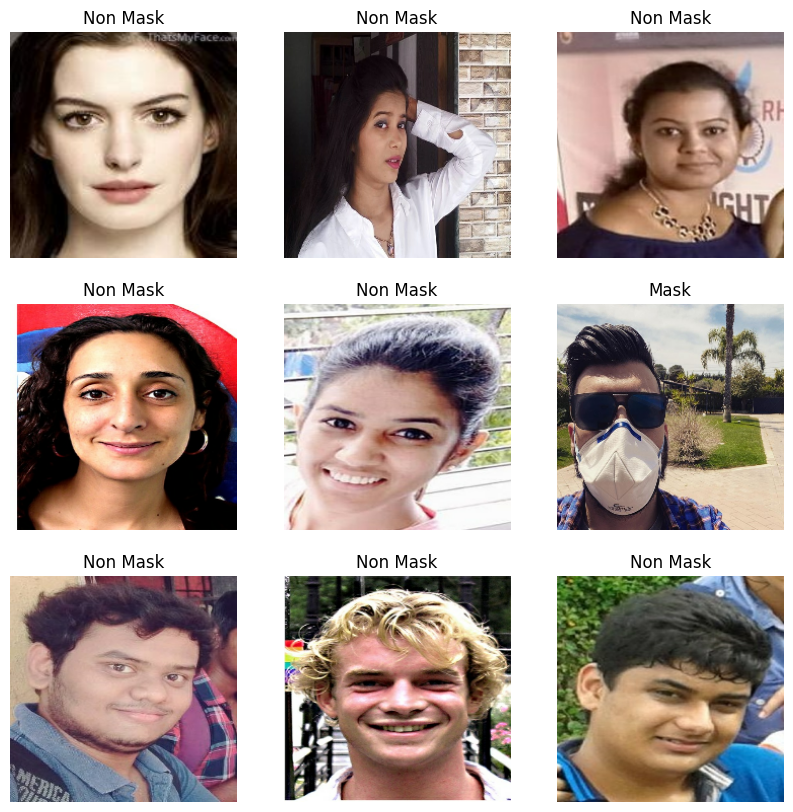

In [113]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [114]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Rescale pixel dari 0-255 menjadi 0-1.

In [115]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Membuat Model menggunakan MobileNetV2 sebagai Base model.

In [116]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Include false agar dapat menggantikan top layer dari model dengan layer khusus kita nanti
                                               weights='imagenet')

Jika telah inisialisasi model, maka memasukin training model.

Sebelum model dilatih, base_model trainable dimatikan dulu. Kita ingin mematikan layer-layer bawah dari model agar tidak menggantikan bobot yang membuatnya mengenal objek.

Layer convolution pada lapisan pertama base_model akan berfungsi sebagai feature extractor.

In [117]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Feature Extraction dalam MobileNetV2 akan mengubah data pixel kita menjadi 7x7x1280 (karena filter yang telah digunakan pada convolution layernya).

In [118]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
feature_batch.numpy()[1]

(32, 7, 7, 1280)


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01261806],
        [0.        , 0.56260014, 0.        , ..., 0.        ,
         0.        , 3.4367485 ],
        [0.        , 1.5651584 , 0.        , ..., 0.        ,
         0.        , 2.7699437 ],
        ...,
        [0.        , 1.9636235 , 0.        , ..., 0.        ,
         0.        , 0.00835085],
        [0.        , 1.4856234 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 2.4746227 ],
        [0.        , 2.7396502 , 0.        , ..., 0.        ,
         0.        , 4.6623907 ],
        [0.        , 0.9398961 , 0.        , ..., 1.2625012 ,
         0.        , 2.2916603 ],
        ...,
        [0.        , 2.6871886 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

Kita akan menggunakan Global Average Pooling 2D layer untuk mengubah vector yang didapati dari base_model menjadi 1280 vector.

Setelah mendapatkan vector tersebut membuat klasifikasi dilakukan menggunakan Dense Layer.

In [119]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dimasukkan Dropout untuk menghindari overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [120]:
# CARA SEBELUMNYA
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(1)
# stacked_layers = [global_average_layer, prediction_layer]
# model = tf.keras.Sequential([base_model] + stacked_layers)

Menetapkan base_learning_rate dan membuat membuat model.

In [121]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
            

Rangkaian Model Terkahir:

In [122]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

### Melatih dan membuat evaluasi
Jika tanpa training hasil yang diberikan adalah:

In [123]:
validation_steps = 6
initial_epochs = 50

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

6/6 [==============================] - 4s 409ms/step - loss: 0.9209 - accuracy: 0.4751


Dapa dilihat, model hanya 0.6077 akurat dalam mendeteksi wajah bermasker. Hal ini tidak bagus karena, jika model menebak maka hasilnya 0.5. Jadi meskipun memiliki bobot dari ImageNet dan architecure MobileNetV2 (transfer learning), model hanya  bisa menentukan wajah bermasker sedikit lebih baik dari penebakan.

Melatih model (layer teratas)

In [124]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
23/23 [==============================] - 17s 600ms/step - loss: 0.7504 - accuracy: 0.5766 - val_loss: 0.6865 - val_accuracy: 0.6243
Epoch 2/50
23/23 [==============================] - 14s 618ms/step - loss: 0.6346 - accuracy: 0.6359 - val_loss: 0.5871 - val_accuracy: 0.6906
Epoch 3/50
23/23 [==============================] - 15s 617ms/step - loss: 0.5435 - accuracy: 0.7159 - val_loss: 0.5101 - val_accuracy: 0.7680
Epoch 4/50
23/23 [==============================] - 14s 589ms/step - loss: 0.4893 - accuracy: 0.7572 - val_loss: 0.4522 - val_accuracy: 0.8122
Epoch 5/50
23/23 [==============================] - 14s 593ms/step - loss: 0.4330 - accuracy: 0.8069 - val_loss: 0.3934 - val_accuracy: 0.8287
Epoch 6/50
23/23 [==============================] - 14s 613ms/step - loss: 0.3700 - accuracy: 0.8662 - val_loss: 0.3468 - val_accuracy: 0.8729
Epoch 7/50
23/23 [==============================] - 16s 666ms/step - loss: 0.3172 - accuracy: 0.8841 - val_loss: 0.3074 - val_accuracy: 0.9171

History dari Training dan Fitting

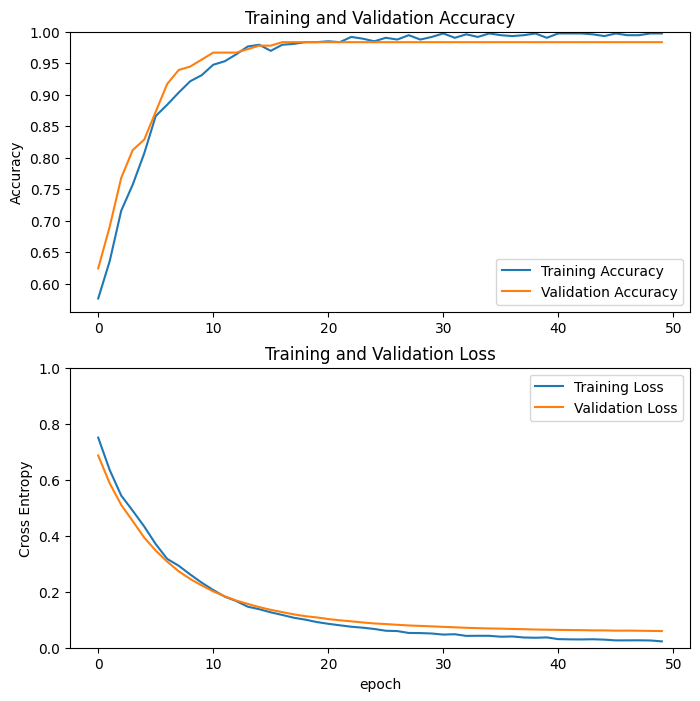

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluasi dengan Testing

In [126]:
testing_steps = 4
loss1,accuracy1 = model.evaluate(test_ds, steps = testing_steps)

4/4 [==============================] - 2s 331ms/step - loss: 0.0261 - accuracy: 1.0000


In [127]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

Fine-tuning model saat epoch = 50

In [128]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [129]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [130]:
# Kita turunin base_learning supaya tidak terlalu mengbuhah seluruh bobot (dengan trainable paramter yang lebih besar) dengan pesat sehingga overfitting  
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), 
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [131]:
model.evaluate(test_ds, steps=4)

4/4 [==============================] - 3s 351ms/step - loss: 0.0261 - accuracy: 1.0000


[0.026127463206648827, 1.0]

In [132]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [133]:
len(model.trainable_variables)

56

In [134]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch= initial_epochs, validation_data = val_ds)


Epoch 51/60
23/23 [==============================] - 26s 888ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0614 - val_accuracy: 0.9779
Epoch 52/60
23/23 [==============================] - 20s 865ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0363 - val_accuracy: 0.9890
Epoch 53/60
23/23 [==============================] - 20s 862ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9890
Epoch 54/60
23/23 [==============================] - 20s 877ms/step - loss: 9.5559e-04 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9890
Epoch 55/60
23/23 [==============================] - 20s 868ms/step - loss: 7.4971e-04 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.9779
Epoch 56/60
23/23 [==============================] - 21s 879ms/step - loss: 2.6136e-04 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9890
Epoch 57/60
23/23 [==============================] - 20s 866ms/step - loss: 4.5516e-04 - accuracy: 1.0000 - val_loss: 0.0422

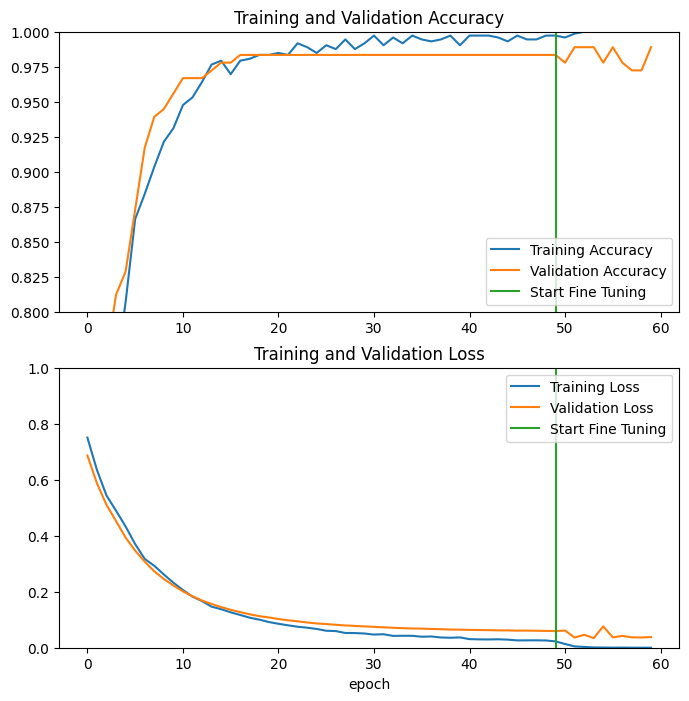

In [138]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Final Evaluation

In [139]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 346ms/step - loss: 3.5271e-04 - accuracy: 1.0000
Test accuracy : 1.0


# Membuat Classifier mengenal beberapa object dalam sebuah gambar

Helper Function

In [186]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]]) 

def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w) 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [ ]:
WIDTH = 600 # 
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)
orig = image
orig = imutils.resize(orig, width = WIDTH)
(H, W) = orig.shape[:2] # 800, 600